In [1]:
# This notebook is used for testing.
# Aim: Calculate magnetic fields of different coil configuration

In [2]:
#Version1:
#Includes formula for calculating the B-field of a straight line from r_start to r_end at any arbitrary position
#Includes formula to calculate B-field of many straight lines; line segments are specified using a tuple_list
#Includes formula to create tuple_list for a single loop

#Version 2:
#Includes function to create tuple list for N loops with same current I

#Version 3:
#Includes cell to plot the coils in 3D

#Version 4:
#Plotting the coils is now a function
#Includes function to draw B-field in x,y or z plane or any plane perpendicular to those planes.

#Version 5:
#Remove most test cells and clean code



#TODOs:
#Include I into parameter list
#Include coils into B-field drawing?

In [3]:
import numpy as np
import scipy.constants
import timeit
import transforms3d #To get rotation matrices
import math
import itertools
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [4]:
#Define constants:
mu_0=scipy.constants.mu_0
pi=scipy.constants.pi

In [5]:
#Define some nice functions:
#Function to normalize a vector:
def normalize(a):
    norm = np.linalg.norm(a)
    if norm==0:
        norm = 1
    return a / norm

#Function to get the sign of the angles of two vectors (e_r_01 and e_r_02) with respect to a third one (e_R):
#angles 1 and 2 define the mathematically positive direction
def angle_sign(def_vec1, def_vec2, ref_vec, vec_of_interest):
    x=np.dot(np.cross(def_vec1,def_vec2),np.cross(ref_vec,vec_of_interest))
    if x>0:
        return 1
    else:
        return -1

# Function to create rotation matrix:
def rotation_matrix(axis, theta):
    """
    Return the rotation matrix associated with counterclockwise rotation about
    the given axis (np.array) by theta radians. See Euler–Rodrigues formula (Wikipedia)
    """
    axis = normalize(axis)
    a = np.cos(theta/2.0)
    b, c, d = -axis*np.sin(theta/2.0)
    aa, bb, cc, dd = a*a, b*b, c*c, d*d
    bc, ad, ac, ab, bd, cd = b*c, a*d, a*c, a*b, b*d, c*d
    return np.array([[aa+bb-cc-dd, 2*(bc+ad), 2*(bd-ac)],
                     [2*(bc-ad), aa+cc-bb-dd, 2*(cd+ab)],
                     [2*(bd+ac), 2*(cd-ab), aa+dd-bb-cc]])

#Function to get the rotation angle in a regular polygon:
def theta(N):
    return 2*pi/N


In [6]:
# Function to calculate magnetic field created by a straight piece of wire:
def B_straight_line(r_start,r_end,r_0,I):
    '''r_0 is the point where the B-field is calculated, the wire starts at r_start and ends at r_end, I is the current from r-start to r_end'''
    #Define vectors and corresponding unit vectors:
    r_01=r_start-r_0
    e_r_01=normalize(r_01)
    r_02=r_end-r_0
    e_r_02=normalize(r_02)
    r_wire=r_end-r_start
    e_r_wire=normalize(r_wire)
    #e_R is the vector from r_0 which is perpendicular to r_wire
    e_R=np.cross(r_wire,np.cross(r_01,r_wire))/(np.linalg.norm(r_wire)*np.linalg.norm(np.cross(r_01,r_wire)))
    R=np.linalg.norm(np.dot(r_01,e_R))*e_R
    
    #Find angles of r_start and r_end with respect to e_R:
    #Problem: By just taking the vector product or the dot product you get only positive angles. So the dot product between e_r_01 and e_r_02 is used to define a right-handed system. If the dot-product of e_R with e_r_01/e_r_02 is in the same direction, their angle is positive with respect to e_R. -> See Function angle_sign(). 
    alpha_1=angle_sign(e_r_01,e_r_02,e_R,e_r_01)*np.arccos((np.linalg.norm(np.cross(r_start,r_wire)))/(np.linalg.norm(r_start)*np.linalg.norm(r_wire)))
    alpha_2=angle_sign(e_r_01,e_r_02,e_R,e_r_02)*np.arccos((np.linalg.norm(np.cross(r_end,r_wire)))/(np.linalg.norm(r_end)*np.linalg.norm(r_wire)))
    
    #Get the unit vector of the B-field
    e_t=np.cross(e_R,e_r_wire)
        
    return mu_0*I/(4*pi*np.linalg.norm(R))*(np.sin(alpha_2)-np.sin(alpha_1))*e_t

In [7]:
#Formula for a circular loop with radius R, B-field measured on axis with distance z to the plane of the loop
def B_circular_loop_onaxis(z,R,I):
    return mu_0*I*R**2/(2*np.power(R**2+z**2,1.5))

#To check the formula, using a square loop with edge length a=0.1m, current I=1A and the B-field is measured at the symmetry axis in the plane of the loop
#Wikipedia, Biot-Savart says for a square loop on the symmetry axis and in the plane of the loop:
def square_loop_wikicheck(a,I):
    return (mu_0*I*2/pi)*np.sqrt(2/(a**2))

In [8]:
#Calculate B-field for snippets of straight wires described by tuples [r_start,r_end]
def B_field(vector_list,r_0,I):
#Map the vector tuples onto the vector arguments of B_straight line (r_start,r_end) and add all resulting B-field vectors together
    return np.sum((map(lambda (r_start,r_end): B_straight_line(r_start,r_end,r_0,I), vector_list)), axis=0)

In [9]:
#Create a function that creates list of vector tuples of one regular polygon loop:
def tuple_list_single_loop(N,r_normal,r_start_side,r_center,r_in,I):
    '''Function that creates list of vector tuples of a single regular polygon loop.
    Takes arguments:
    N: Number of edges of the polygon
    r_normal: normal vector of the plane of the loop
    r_start_side: vector from the center of the loop to one corner; defines rotational orientation of the loop
    r_center: vector defining the center of the loop
    r_in: variable defining the inner radius of the polygon'''
    #Test that e_start and e_normal are perpendicular
    if 0.0!=np.dot(r_normal,r_start_side):
        print("vectors are not perpendicular!")
    e_normal=normalize(r_normal)
    e_start_side=normalize(r_start_side)
    r_out=r_in/(np.cos(pi/N))
    e_start_corner=np.dot(rotation_matrix(e_normal,theta(N)/2),e_start_side) 
    r_start_corner=r_out*e_start_corner

    #Create list of vector lists:
    #Use the starting edge vector and rotate it around the symmetry axis by 2pi/N to get the next corner. Every segment goes from one to the next corner.
    tuple_list=[(r_center+np.dot(rotation_matrix(e_normal,i*theta(N)),r_start_corner),r_center+np.dot(rotation_matrix(e_normal,(i+1)*theta(N)),r_start_corner)) for i in range(N)]
    return tuple_list

In [10]:
#Function to create tuple_list for several regular polygon loops with changing parameters r_center,r_in and fixed parameters N,r_normal,r_start_side
def tuple_list_N_loop(N,r_normal,r_start_side,param_list):
    '''Function that creates list of vector tuples of a single regular polygon loop.
    Takes arguments:
    N: Number of edges of the polygon
    r_normal: normal vector of the plane of the loop
    r_start_side: vector from the center of the loop to one corner; defines rotational orientation of the loop
    param_list: parameter list with tuples (r_center,r_in) where
    r_center: vector defining the center of the loop
    r_in: variable defining the inner radius of the polygon'''
    #Create a list of single loop tuple lists 
    list_of_tuple_lists=map(lambda (r_center,r_in):tuple_list_single_loop(N,r_normal,r_start_side,r_center,r_in,I),param_list)
    #Flatten the list to one big list
    flattend_tuple_list=list(itertools.chain.from_iterable(list_of_tuple_lists))
    return flattend_tuple_list

In [11]:
#Convert tuple_list into np.array with x,y,z where x,y and z are 1D arrays that can be used for 3D plotting
def tuple_list_converter(tuple_list):
    #convert tuple_list to array
    tuple_array=np.array(tuple_list)
    #Check that tuple list has correct form:
    n,t,d=np.shape(tuple_array)
    if (t,d)!=(2,3) or n==0:
        print('Tuple list has not correct shape')
    #Rearrange array, such that it consists of three 1D arrays
    rearranged_tuple_array=tuple_array.reshape((n*t,d)).T
    return rearranged_tuple_array

In [12]:
#Function to plot the current loop
def loop_plot(N,r_normal,r_start_side,param_list):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    threeD_array=tuple_list_converter(tuple_list_N_loop(N,r_normal,r_start_side,param_list))
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    ax.plot(threeD_array[0],threeD_array[1],threeD_array[2],zdir='z')
    plt.savefig('loop_plot_test.pdf')
    plt.show()
    return

In [19]:
#Function to plot the B-field in two dimensions:
def B_plot(N,r_normal,r_start_side,param_list,I,x,y,z):
    '''N: number of loops
    r_normal: normal vector of coil area
    r_start_side: vector defining rotational orientation around r_normal
    param_list: parameter list r_center=vector to loop center,r_in=inner radius of loop
    I: loop current
    x,y,z: parameter space for x,y,z defined using np.linspace(); as only a 2D plot is possiple, for one axis y=np.linspace(a,a,1)
    '''
    #Check which axis shall be plotted:
    if np.size(x)==1:
        a1,a2=y,z
        B_coord1,B_coord2=1,2
        xlabel,ylabel='y','z'
        const_label=' x = '
        axis_const=x[0]
    elif np.size(y)==1:
        a1,a2=x,z
        B_coord1,B_coord2=0,2
        xlabel,ylabel='x','z'
        const_label=' y = '
        axis_const=y[0]
    elif np.size(z)==1:
        a1,a2=x,y
        B_coord1,B_coord2=0,1
        xlabel,ylabel='x','y'
        const_label=' z = '
        axis_const=z[0]
    else:
        print('You have chosen the wrong parameter space x,y,z for plotting')
    
    #Create a meshgrid from the given parameter space for plotting:
    g = np.meshgrid(x, y, z)
    #Create a list with all position vectors given by the meshgrid:
    positions = np.vstack(map(np.ravel, g)).T

    #Create a B-field matrix containing the B-field vectors at the positions vectors
    B=np.zeros(np.shape(positions))
    for i in range(np.shape(positions)[0]):
        B[i]=B_field(tuple_list_N_loop(N,r_normal,r_start_side,param_list),positions[i],I)
    
    #Convert the 1D array of B-field vectors back into a meshgrid-like structure as needed for plotting:
    #Use np.transpose for that because B has shape (n,m,3) and needs (m,n,3)
    B=np.transpose(np.reshape(B,(np.shape(a1)[0],np.shape(a2)[0],3)),(1,0,2))
    #Note that B_x=B[:,:,0],B_y=B[:,:,1],B_z=B[:,:,2]

    #Code for plotting
    im = plt.streamplot(a1,a2,B[:,:,B_coord1],B[:,:,B_coord2])  
    plt.xlabel(xlabel+'-axis')
    plt.ylabel(ylabel+'-axis')
    
    plt.title('B-field for'+const_label+str(axis_const))
    plt.savefig('B_field_test.pdf')
    plt.show()
    

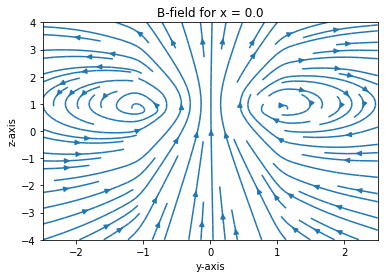

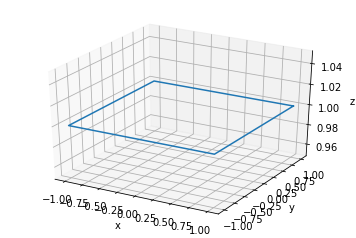

In [20]:
#Test the function to plot the current loop
r_normal=np.array([0,0,1])
r_start_side=np.array([1,0,0])
N=4
r_0=np.array([0,0,0])

#Param_list=[(r_center_1,r_in_1),...]
param_list=[(np.array([0,0,1]),1)]#,(np.array([0,0,-1]),1)
I=1

y=np.linspace(-2.5,2.5,20)
x=np.linspace(0,0,1)
z=np.linspace(-4,4,20)
#print(np.size(y))

#Plotting functions
B_plot(N,r_normal,r_start_side,param_list,I,x,y,z)
loop_plot(N,r_normal,r_start_side,param_list)